## 3D Prediction using StarDist

Repo: https://github.com/stardist/stardist?tab=readme-ov-file

## Libraries

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
matplotlib.rcParams['image.interpolation'] = 'none'
%matplotlib inline

from csbdeep.utils import normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap

# Custom packages
from auxiliary import values as v
from auxiliary.gpu.gpu_tf import (
    increase_gpu_memory, 
    set_gpu_allocator, 
    clear_session
)
from auxiliary.data import imaging


### Data

In [2]:
img_name = '20190806_E6_DAPI_decon_0'
img_path = v.data_path + f'/Gr4/RawImages/Nuclei/{img_name}.5.nii.gz'
test_img = imaging.read_nii(img_path)

In [3]:


test_img = test_img.astype(np.uint8).reshape(
    test_img.shape[0], 
    test_img.shape[1], 
    test_img.shape[2]
)

# aux = np.zeros((512, 512, test_img.shape[2]))
# for i in range(test_img.shape[2]):
#     aux[..., i] = cv2.resize(test_img[..., i], (512, 512))
test_img_norm = normalize(test_img, 1, 99.8, axis=(0, 1, 2))

In [5]:
# def crop_sliding_windows(img, ws=128):
#     """
#     Divide the image into smaller windows of the same size 
#     :param img: 
#     :param ws: 
#     :return: 
#     """
#     n_slices = img.shape[0] // ws
#     
#     sliding_img = np.zeros(shape=(
#         ws, ws, img.shape[-1],
#         n_slices * n_slices
#     ), dtype=np.float16)
#     
#     sliding_positions = []
#     for i in range(n_slices):
#         for j in range(n_slices):
#             sliding_img[..., i * n_slices + j] = img[
#                 i * ws : (i + 1) * ws, 
#                 j * ws : (j + 1) * ws, 
#                 :
#             ]
#             sliding_positions.append((i, j))
#             
#     return sliding_img, sliding_positions
#     
# sliding_img, sliding_positions = crop_sliding_windows(test_img_norm, 64)

In [6]:
# print(sliding_img.shape)

In [7]:
# cv2.imshow('img', test_img[..., 270])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [8]:
# for i in range(16):
#     cv2.imshow('img', sliding_img[..., 270, i])
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

### Model

In [9]:
# set_mixed_precision()
increase_gpu_memory()
set_gpu_allocator()

In [23]:
from stardist.models import StarDist3D

model_idx = 2
model_names = [
    'n1_stardist_96_(1.6, 1, 1)_(48, 64, 64)_(1, 1, 1)',
    'n2_stardist_96_(1.6, 1, 1)_(48, 64, 64)_(1, 1, 1)',
    'n3_stardist_96_(1.6, 1, 1)_(48, 64, 64)_(1, 1, 1)'
]

model_path = '../models/stardist_models/' + model_names[model_idx] + '/'
model = StarDist3D(None, name=model_names[model_idx], basedir='../models/stardist_models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.511542, nms_thresh=0.3.


In [11]:
# import tensorflow as tf
# 
# 
# clear_session()
# 
# tf.debugging.set_log_device_placement(True)
# strategy = tf.distribute.MirroredStrategy() 
# 
# with strategy.scope():
#     try:
#         model.predict_instances(test_img_norm)
#     except tf.errors.ResourceExhaustedError as e:
#         print(f"ResourceExhaustedError during inference: {e}")


As we dont have enough memory to predict the whole image at once, we will divide it into smaller windows and predict them separately. 

LO PUEDE HACER STARDIST INTERNAMENTE

In [12]:
print(test_img_norm.shape)

(1024, 1024, 548)


In [13]:
import tensorflow as tf


clear_session()

tf.debugging.set_log_device_placement(True)
strategy = tf.distribute.MultiWorkerMirroredStrategy()

with strategy.scope():
    try:
        labels, details = model.predict_instances(
            test_img_norm,
            n_tiles = (8, 8, 8),
            show_tile_progress = True,
            verbose = 1,
            axes = 'YXZC'
        )
    except tf.errors.ResourceExhaustedError as e:
        print(f"ResourceExhaustedError during inference: {e}")

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CommunicationImplementation.AUTO


100%|██████████| 512/512 [15:14<00:00,  1.79s/it]


predicting instances with nms_thresh = 0.3
non-maximum suppression...
Non Maximum Suppression (3D) ++++ 
NMS: n_polys  = 6210507 
NMS: n_rays   = 96  
NMS: n_faces  = 188 
NMS: thresh   = 0.300 
NMS: use_bbox = 1 
NMS: use_kdtree = 1 
NMS: using OpenMP with 8 thread(s)
NMS: precompute volumes, bounding boxes, etc
precompute done
NMS: calculated anisotropy: 1.69 	 1.26 	 1.00 
NMS: building kdtree...
NMS: starting suppression loop
|################################################# | [98 % suppressed]
NMS: Function calls:
NMS: ~ bbox+out: 67553139
NMS: ~ inner:    10066117
NMS: ~ kernel:   10050176
NMS: ~ convex:    6251791
NMS: ~ render:    3823861
NMS: Excluded intersection:
NMS: + pretest:  57487022
NMS: + convex:    2427930
NMS: Function calls timing:
NMS: / kernel:   11343.38 s  (1.13 ms per call)
NMS: / convex:   11727.56 s  (1.88 ms per call)
NMS: / render:   9139.09 s  (2.39 ms per call)
NMS: Suppressed polyhedra:
NMS: # inner:       15941 / 6210507  (0.26 %)
NMS: # kernel:    37


Qhull output at end
Qhull precision warning: repartition point p71 from f265 as a outside point above a hidden facet f178 dist 0.0012 nearest vertices 0.015

Qhull output at end
Qhull precision warning: repartition point p220 from f250 as a outside point above a hidden facet f162 dist 3.3e-05 nearest vertices 0.073

Qhull output at end
Qhull precision warning: repartition point p7 from f199 as a outside point above a hidden facet f198 dist 0.00018 nearest vertices 0.13

Qhull output at end
Qhull precision warning: repartition point p149 from f99 as a outside point above a hidden facet f151 dist 0.004 nearest vertices 0.086

Qhull output at end
Qhull precision warning: repartition point p32 from f302 as a outside point above a hidden facet f215 dist 4.6e-05 nearest vertices 0.12

Qhull output at end
Qhull precision warning: repartition point p121 from f260 as a outside point above a hidden facet f258 dist 4.5e-05 nearest vertices 0.057

Qhull output at end
Qhull precision warning: repa

+++++++++++++++ polyhedra to label +++++++++++++++ 
n_polys           = 83367 
n_rays            = 96 
n_faces           = 188 
nz, ny, nx        = 1024 1024 548 
use_overlap_label = 0 
overlap_label     = 0 


In [14]:
# from auxiliary.timer import LoadingBar
# 
# 
# clear_session()
# 
# tf.debugging.set_log_device_placement(True)
# # strategy = tf.distribute.MirroredStrategy()    
# strategy = tf.distribute.MultiWorkerMirroredStrategy()    
#         
# test_slices = np.stack([sliding_img[..., i] for i in range(sliding_img.shape[-1])])
#         
# bar = LoadingBar(len(test_slices), length=50)
#         
# with strategy.scope():
#     
#     def infer_slice(slice_):
#         slice_ = slice_[0]
#         labels, details = model.predict_instances(slice_)
#         return labels, details
# 
#     try: 
#         test_slices = test_slices[..., np.newaxis]
#         dataset = tf.data.Dataset.from_tensor_slices(test_slices)
#         dataset = dataset.batch(1)  
#     
#         results = []
#         for slice_batch in dataset:
#             labels, details = infer_slice(slice_batch)
#             results.append((labels, details))
#             bar.update()
#             # clear_session()
#     except tf.errors.ResourceExhaustedError as e:
#         print(f"ResourceExhaustedError during inference: {e}")
#         clear_session()
# 
# labels, details = zip(*results)
# # labels = merge_sliding_windows(labels, sliding_positions, 128)

In [26]:
save_tiff_imagej_compatible('example_labels.tif', labels, axes='YXZ')
# # Save details dictionary as JSON
# import json
# 
# with open('example_details.json', 'w') as f:
#     json.dump(details, f)

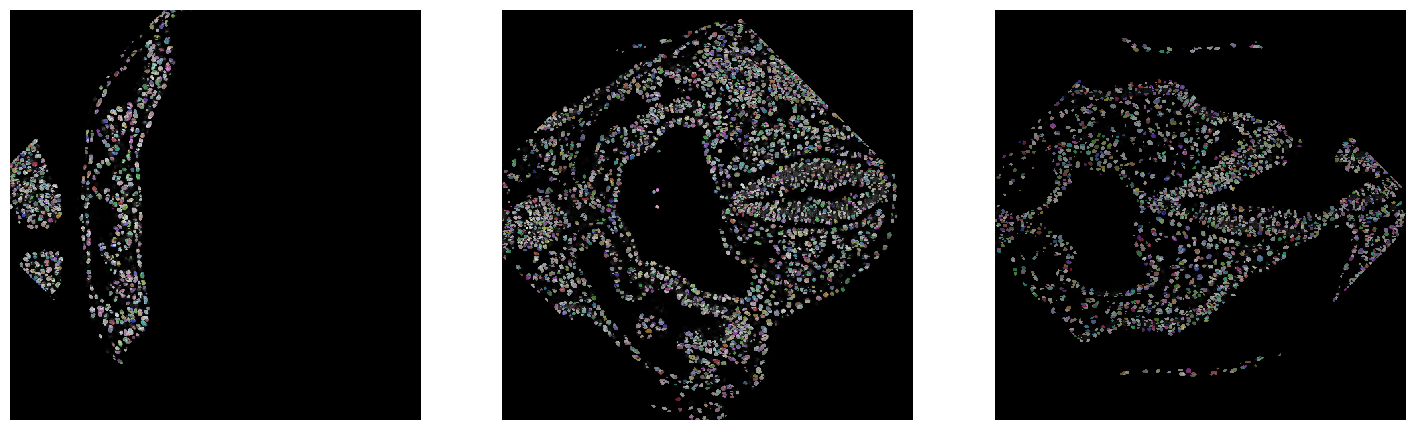

In [19]:
def print_labels_slice(labels, z=[100, 270, 400]):
    fig, ax = plt.subplots(1, len(z), figsize=(18, 9))
    if len(z) == 1:
        ax = [ax]
        
    for i in range(len(z)):
        ax[i].imshow(test_img_norm[..., z[i]], cmap='gray');
        ax[i].imshow(
            labels[..., z[i]], cmap=random_label_cmap(), 
            interpolation='nearest', alpha=.5
        )
        ax[i].axis('off')

    plt.show()

print_labels_slice(labels, [100, 270, 400])